# About
This notebook is the second notebook in a 2-notebook series to training a DeepAR model on AWS Sagemaker. It follows from the eda_notebook where we were processing electricity prices timeseries dataset into a JSON Lines format, which DeepAR expects.

The aim is to utilise DeepAR's recurrent neural network architecture, finetune its weights according to Octopus' electricity dataset and finally, deploy a model endpoint for making model half-hourly export price predictions for the next 7 days given a context window of 7 days.<br>(Reading: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)

# Import Libraries

In [144]:
import sagemaker
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
import boto3
import pandas as pd
from datetime import timedelta
import json
import matplotlib.pyplot as plt
import calendar
import matplotlib.dates as mdates

INFO:matplotlib.font_manager:generated new fontManager


I have manually created a s3 bucket with the name as below. I have created the folder structure data/train and data/test inside of this bucket and uploaded my train.json and test.json in the folders respectively. 

In [18]:
# define s3 objects
bucket_name = 'sagemaker-octopus-price-predictor'
train_object_key = 'data/train/train'
test_object_key = 'data/test/test'
model_object_key = 'model/deepar_model'
s3_output_path = "s3://{}/{}".format(bucket_name,model_object_key)

# define DeepAR model parameters
freq = "30min"
context_length = 7 * 48 # 7 days
prediction_length = 7 * 48 # 7 days

# Create and Train Model

In [28]:
deepar_container = image_uris.retrieve(framework='forecasting-deepar',region='eu-north-1')

hyperparameters = {
    "time_freq": freq,
    "epochs": "100",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

# build DeepAR model
estimator = sagemaker.estimator.Estimator(
    image_uri=deepar_container,
    sagemaker_session = sagemaker.Session(),
    hyperparameters=hyperparameters,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    base_job_name='deepar-octopus-electricity-dataset',
    output_path = s3_output_path)

# define dype and s3 URI for training and test datasets
train_input = TrainingInput("s3://{}/{}".format(bucket_name,train_object_key))
test_input = TrainingInput("s3://{}/{}".format(bucket_name,test_object_key))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [ ]:
# execute training job
estimator.fit({'train':train_input,'test':test_input})

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: deepar-octopus-electricity-dataset-2025-09-21-13-16-27-785


2025-09-21 13:16:30 Starting - Starting the training job...
2025-09-21 13:17:01 Downloading - Downloading input data...
2025-09-21 13:17:15 Downloading - Downloading the training image.........
2025-09-21 13:18:36 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.9/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[09/21/2025 13:18:52 INFO 140207348086592] Reading default configuration from /opt/amazon/lib/python3.9/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'stud

# Create Endpoint and Predictor

# Evaluate Predictions

In [85]:
# load data from s3 bucket that was uploaded during eda_notebook
s3 = boto3.client('s3')
object_response = s3.get_object(Bucket=bucket_name,Key='data/data.csv')
# decode response body
body = object_response['Body'].read().decode('utf-8')
df = pd.read_csv(StringIO(body),index_col=0,parse_dates=True)

In [94]:
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type="ml.m5.large")

INFO:sagemaker:Creating model with name: deepar-octopus-electricity-dataset-2025-09-21-17-25-41-435
INFO:sagemaker:Creating endpoint-config with name deepar-octopus-electricity-dataset-2025-09-21-17-25-41-435
INFO:sagemaker:Creating endpoint with name deepar-octopus-electricity-dataset-2025-09-21-17-25-41-435


-------!

In [118]:
predictor.serializer = JSONSerializer()

## during Jan-Aug 2025
The model was trained on data between Jan-Aug 2024 so it is expected to perform well on this data interval. Let us choose the first week of each month as our evaluation dataset examples

In [246]:
def predict(predictor, start_dates, quantiles):
    """
    Inputs
    predictor: Predictor object that our estimator has been deployed to
    start_dates: List of strings for start datetime of each timeseries example(1D List)
    quantiles: List of floats representing the quantiles we want to be returned in our response
    """

    instances = [
        {
            "start":start_date,
            "target":df[pd.Timestamp(start_date):pd.Timestamp(start_date)+timedelta(weeks=1)-timedelta(minutes=30)].iloc[:,0].tolist()
                }
    for start_date in start_dates]
    
    request = {
        "instances": instances,
        "configuration": {
            "num_samples": 10,
            "output_types": ["mean","quantiles","samples"],
            "quantiles": quantiles
        }
    }

    return json.loads(predictor.predict(request))

In [247]:
# make predictions
start_dates = [f"2025-{str(k).zfill(2)}-01 00:00:00" for k in range(1,9)]
quantiles=["0.5","0.9"]
response = predict(predictor, start_dates, quantiles)

In [248]:
def plot(response, context_start_dates,df):
    start_timestamps = [pd.Timestamp(date)+timedelta(weeks=1) for date in context_start_dates]
    end_timestamps = [tstamp+timedelta(weeks=1)-timedelta(minutes=30) for tstamp in start_timestamps]
    month_nos = [tstamp.month for tstamp in start_timestamps]
    
    n_rows = -(len(context_start_dates)//-2)
    fig,axs = plt.subplots(n_rows,2,figsize=(20,n_rows*4.5))
    axx = axs.ravel()
    for i in range(len(context_start_dates)):
        pred = response['predictions'][i]
        actual_values = df[start_timestamps[i]:end_timestamps[i]]
        timeinterval = actual_values.index
        axx[i].plot(timeinterval,actual_values)
        axx[i].plot(timeinterval,pred['mean'])
        axx[i].xaxis.set_major_formatter(mdates.DateFormatter("%d"))
        axx[i].set_ylabel('Export Price (p/kWh)')
        axx[i].set_title(f'{calendar.month_abbr[month_nos[i]]}')
    axx[len(context_start_dates)-2].set_xlabel('Day of Month')
    axx[len(context_start_dates)-1].set_xlabel('Day of Month')
    fig.legend(labels=['Actual','Prediction'], loc='lower center')

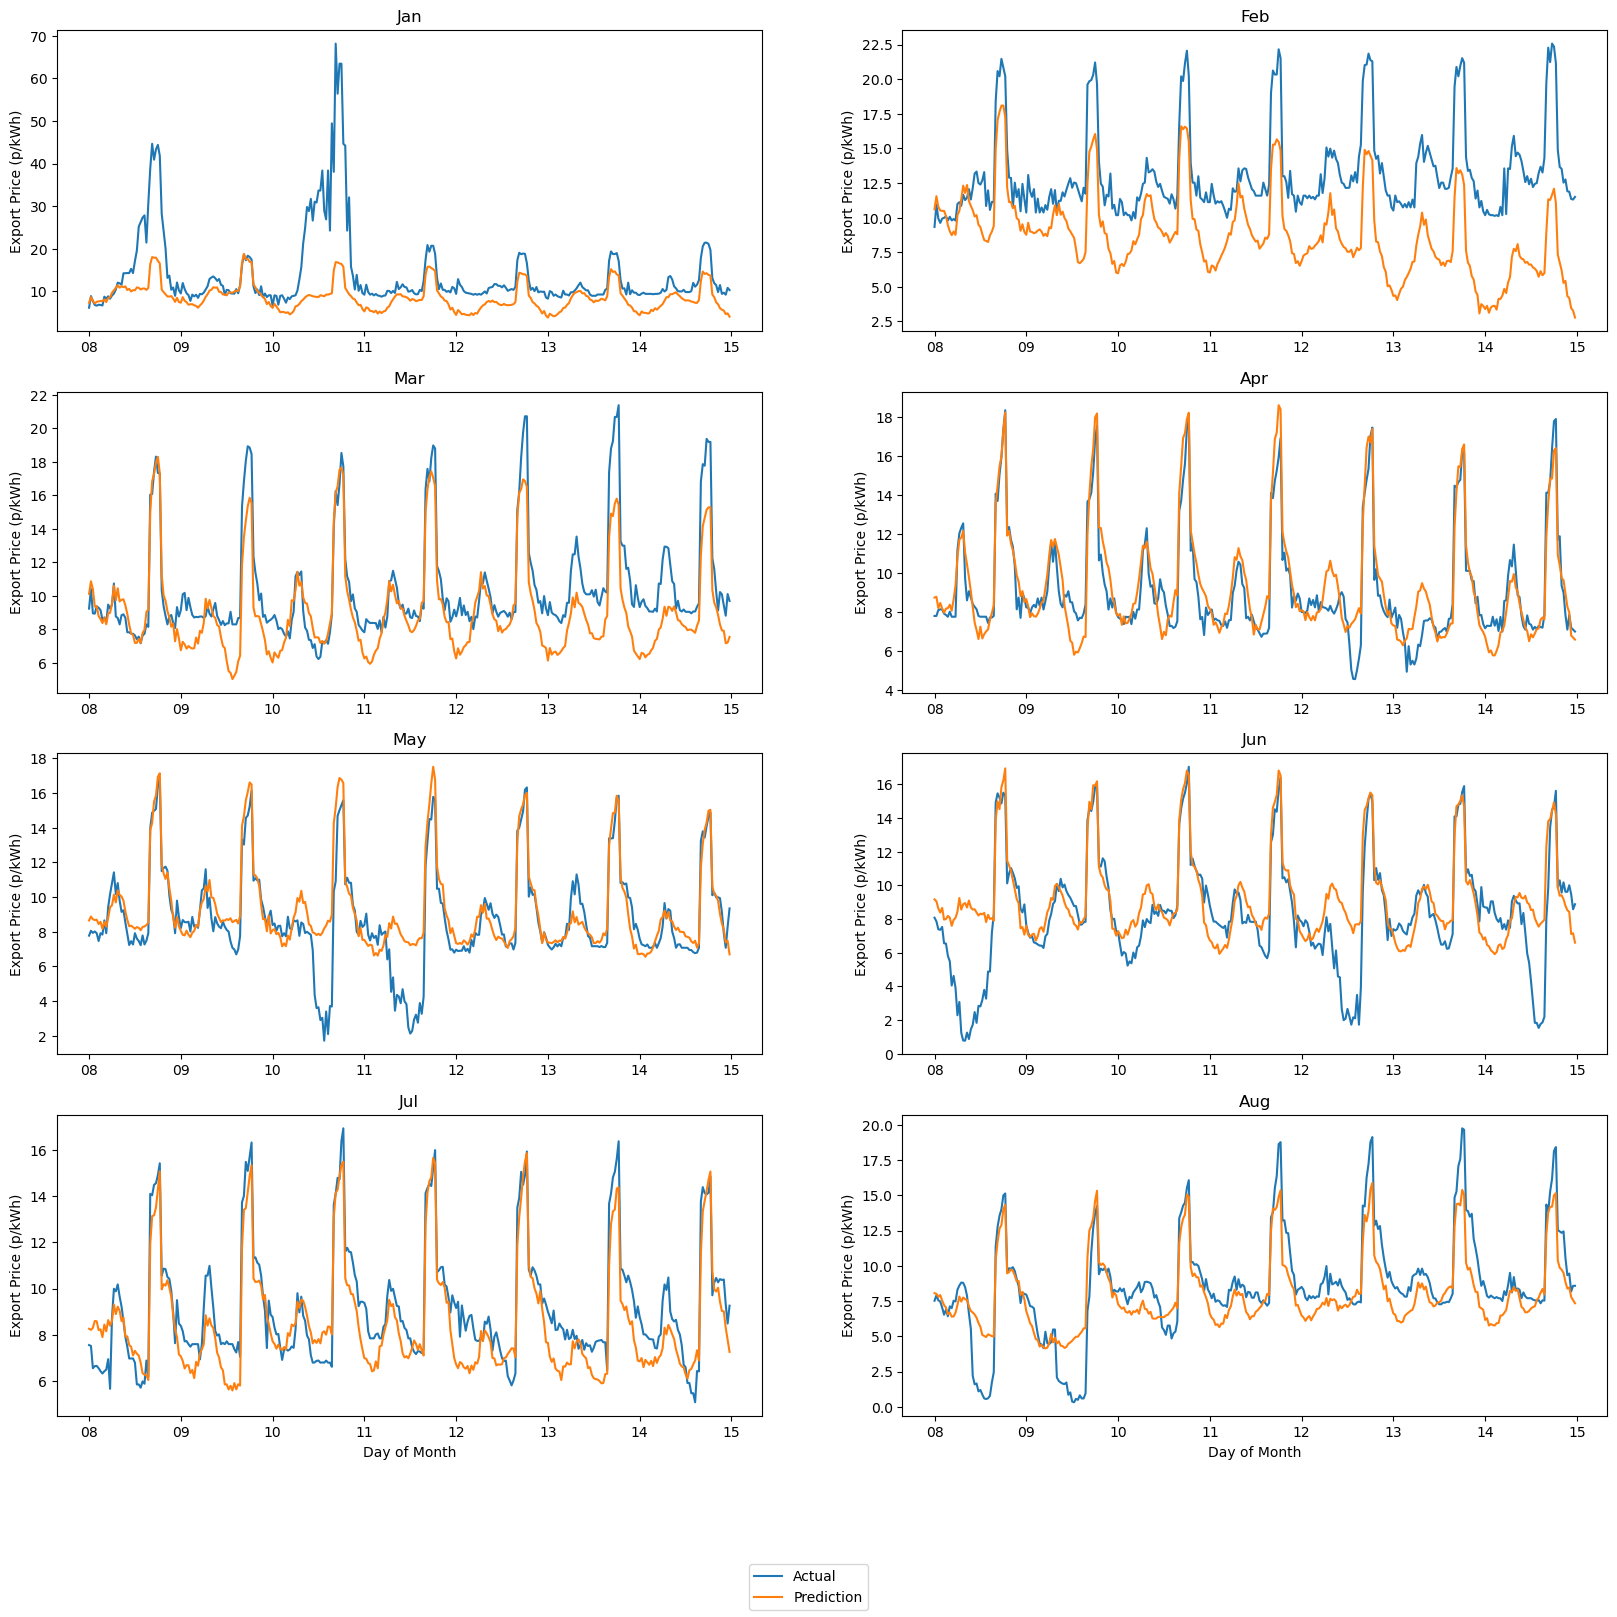

In [249]:
plot(response,start_dates,df)

## during Sep-Dec 2024
The training dataset did not include any windows of data from this date interval. Thus, we expect it to perform poorly, unless these months show similar patterns to the first 8 months of the year.

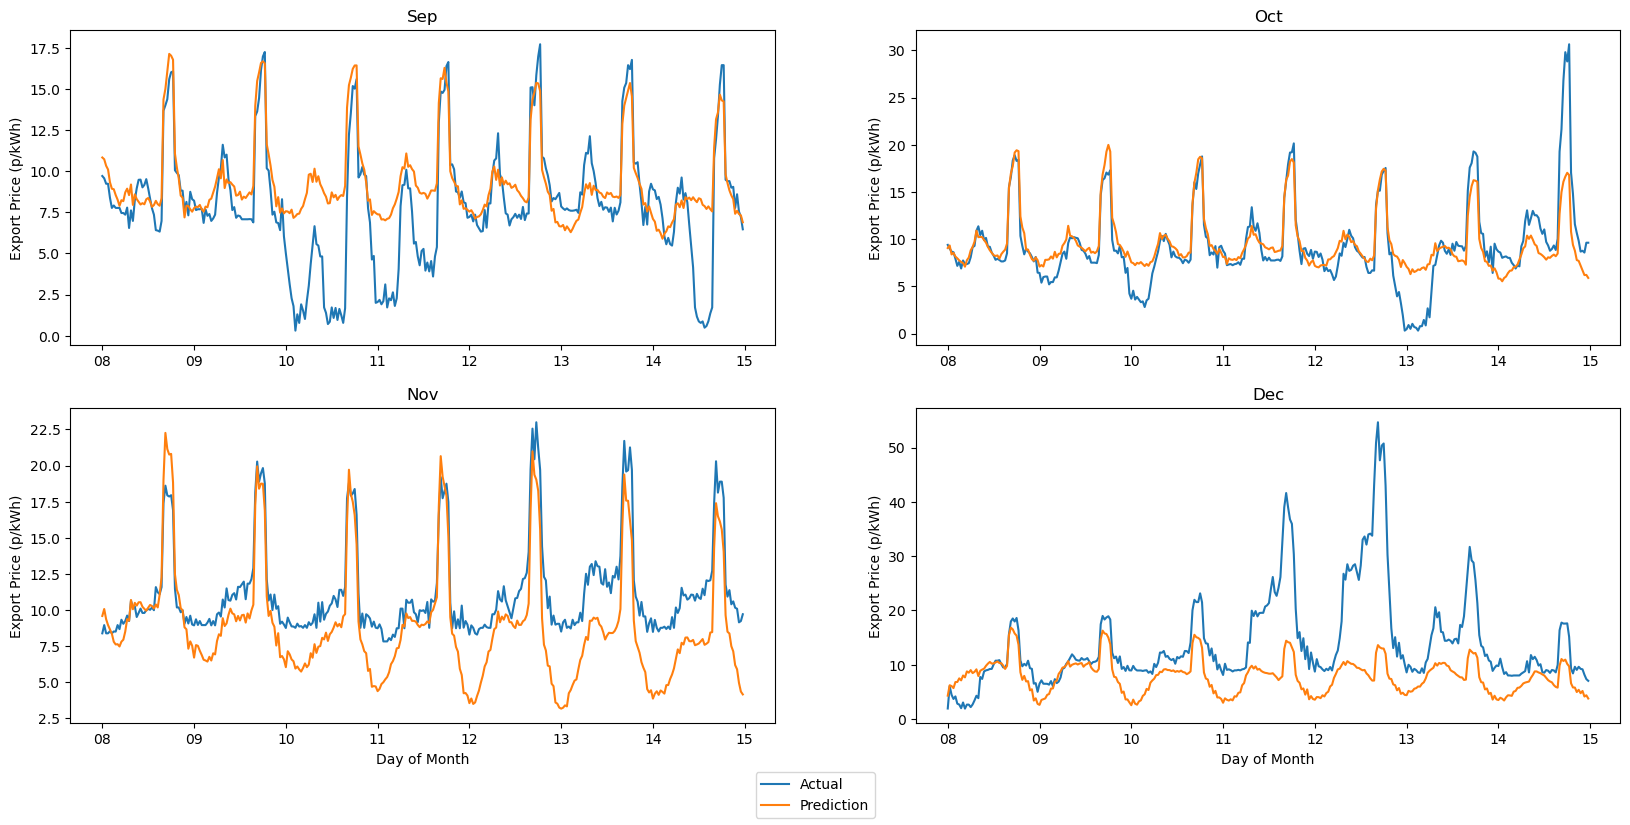

In [250]:
# make predictions
start_dates = [f"2024-{str(k).zfill(2)}-01 00:00:00" for k in range(9,13)]
quantiles=["0.5","0.9"]
response = predict(predictor, start_dates, quantiles)
plot(response,start_dates,df)

The algorithm doesn't do badly in the unseen months, but noticeably worse in September and December. It seems to have learnt the daily pattern well, but fails to accurately predict the magnitude at which export prices rise during peak hours on some days (as evident on 11th and 12th December)

In [244]:
def plot_both_windows(response, context_start_dates,df):
    context_start_timestamps = [pd.Timestamp(date) for date in context_start_dates]
    start_timestamps = [pd.Timestamp(date)+timedelta(weeks=1) for date in context_start_dates]
    end_timestamps = [tstamp+timedelta(weeks=1)-timedelta(minutes=30) for tstamp in start_timestamps]
    month_nos = [tstamp.month for tstamp in start_timestamps]
    
    n_rows = -(len(context_start_dates)//-2)
    fig,axs = plt.subplots(n_rows,2,figsize=(20,n_rows*4.5))
    axx = axs.ravel()
    for i in range(len(context_start_dates)):
        pred = response['predictions'][i]
        time_pred = df[start_timestamps[i]:end_timestamps[i]].index
        actual_values = df[context_start_timestamps[i]:end_timestamps[i]]
        time_act = actual_values.index
        axx[i].plot(time_act,actual_values)
        axx[i].plot(time_pred,pred['mean'])
        axx[i].xaxis.set_major_formatter(mdates.DateFormatter("%d"))
        axx[i].set_ylabel('Export Price (p/kWh)')
        axx[i].set_title(f'{calendar.month_abbr[month_nos[i]]}')
        axx[i].axvspan(time_pred[0], time_pred[-1], color='orange', alpha=0.2, label='Prediction Window')
    axx[len(context_start_dates)-2].set_xlabel('Day of Month')
    axx[len(context_start_dates)-1].set_xlabel('Day of Month')
    fig.legend(labels=['Actual','Prediction'], loc='lower center')

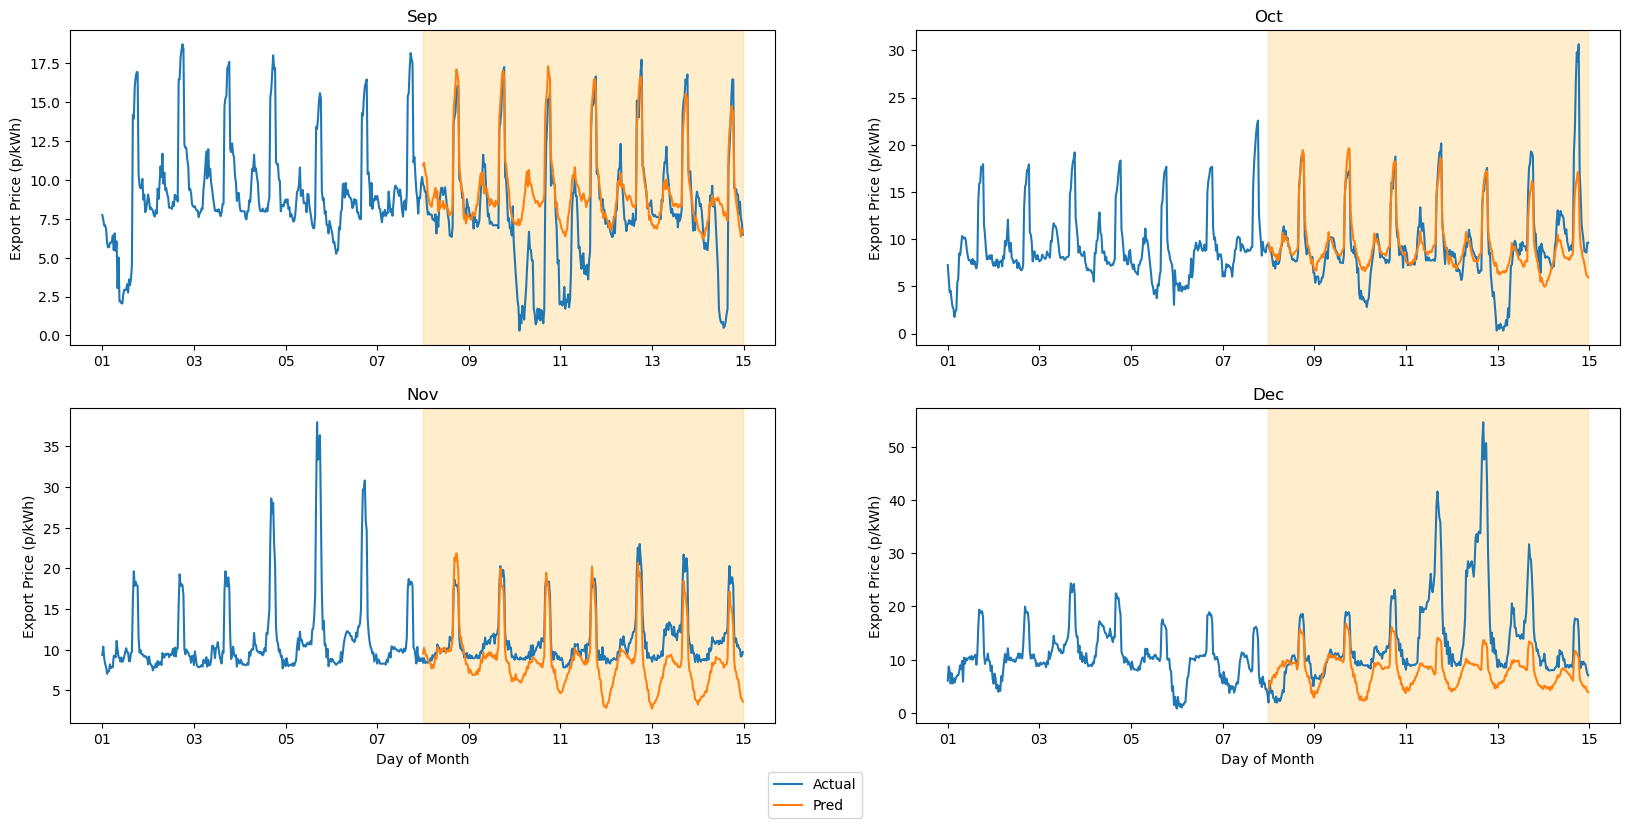

In [245]:
# context window and prediction window in one plot
plot_both_windows(response,start_dates,df)

The unshaded portion on the left shows the context window, what was fed into our DeepAR model - 7 days worth or 336 half-hourly electricity prices.<br>
The shaded portion on the right shows the predicted values along with the actual values. You can see the model plays it safe by sticking to the price ranges it has seen in the prior 7 days.

# Clean Up
I manually emptied and deleted my S3 bucket, along with any CloudWatch logs

In [254]:
# Deletes the SageMaker model
predictor.delete_model()

In [256]:
# Tears down the SageMaker endpoint and endpoint configuration
predictor.delete_endpoint(delete_endpoint_config=False)

INFO:sagemaker:Deleting endpoint with name: deepar-octopus-electricity-dataset-2025-09-21-17-25-41-435


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # Tears down the SageMaker endpoint and endpoint configuration                               │
│ ❱ 2 predictor.delete_endpoint(delete_endpoint_config=False)                                      │
│   3                                                                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/base_predictor.py:5 │
│ 29 in delete_endpoint                                                                            │
│                                                                                                  │
│   526 │   │   if delete_endpoint_config:                                                         │
│   527 │   │   │   self._delete_endpoint_config()                                                 │
│   528 │   │                                                                                      │
│ ❱ 529 │   │   self.sagemaker_session.delete_endpoint(self.endpoint_name)                         │
│   530 │                                                                                          │
│   531 │   def delete_predictor(self, wait: bool = False) -> None:                                │
│   532 │   │   """Delete the Amazon SageMaker inference component or endpoint backing this pred   │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py:5214 in  │
│ delete_endpoint                                                                                  │
│                                                                                                  │
│   5211 │   │   │   endpoint_name (str): Name of the Amazon SageMaker ``Endpoint`` to delete.     │
│   5212 │   │   """                                                                               │
│   5213 │   │   logger.info("Deleting endpoint with name: %s", endpoint_name)                     │
│ ❱ 5214 │   │   self.sagemaker_client.delete_endpoint(EndpointName=endpoint_name)                 │
│   5215 │                                                                                         │
│   5216 │   def delete_endpoint_config(self, endpoint_config_name):                               │
│   5217 │   │   """Delete an Amazon SageMaker endpoint configuration.                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/client.py:602 in     │
│ _api_call                                                                                        │
│                                                                                                  │
│    599 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    600 │   │   │   │   )                                                                         │
│    601 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  602 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    603 │   │                                                                                     │
│    604 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    605                                                                                           │
│                                                            